# Version 1

The code starts by importing the necessary libraries and installing tensorflow-addons if it's not already installed. The required libraries are then imported, including TensorFlow, scikit-learn, and TensorFlow Addons. TensorFlow Datasets is also imported for loading the PlantVillage dataset.

In [ ]:
# Required Libraries
!pip install tensorflow-addons
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


The PlantVillage dataset is loaded using the tfds.load function. It is split into training and validation sets with an 80-20 split ratio. The as_supervised=True argument ensures that the dataset is returned in a tuple of (image, label) format. The with_info=True argument retrieves information about the dataset.

In [ ]:
# Load the PlantVillage dataset
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteCWW21T/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


The preprocess_data function is defined to preprocess the images and labels. The images are cast to float32 and normalized to the range [0, 1]. The labels are one-hot encoded using tf.one_hot based on the number of classes in the dataset.

In [ ]:
# Preprocess function
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=ds_info.features['label'].num_classes)
    return image, label

Both the training and validation datasets are preprocessed using the map function with the preprocess_data function. They are then batched and prefetched for better performance during training.

In [ ]:
# Preprocess the datasets
train_ds = ds_train.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = ds_val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Batch the datasets
batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

The number of classes and class names are printed to verify the dataset's properties.

In [ ]:
class_names = ds_info.features['label'].names
print(f"Class names: {class_names}")
print(len(class_names))

Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus

Next, the model architecture is defined using the InceptionV3 base model. The base model is loaded with pre-trained weights from the ImageNet dataset and excludes the top classification layer. The pre-trained layers are frozen by setting layer.trainable = False. A new classification layer is added on top of the base model, consisting of a global average pooling layer, a dense layer with 256 units and ReLU activation, and a final dense layer with num_classes units and softmax activation.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model_InceptionV3.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [ ]:
num_classes = 38
num_epochs = 20
# Load the pre-trained InceptionV3 model without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)


87910968/87910968 [==============================] - 0s 0us/step


The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.

In [ ]:
# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model is trained using the fit function, providing the training and validation datasets. The checkpoint_callback saves the best model based on the validation loss. The training is performed for num_epochs epochs.


In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[checkpoint_callback])

Epoch 1/20
1358/1358 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.8320
Epoch 1: val_loss improved from inf to 0.31908, saving model to best_model_InceptionV3.h5
1358/1358 [==============================] - 43s 22ms/step - loss: 0.5682 - accuracy: 0.8320 - val_loss: 0.3191 - val_accuracy: 0.8955
Epoch 2/20
1357/1358 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.9140
Epoch 2: val_loss did not improve from 0.31908
1358/1358 [==============================] - 27s 20ms/step - loss: 0.2638 - accuracy: 0.9140 - val_loss: 0.3259 - val_accuracy: 0.8951
Epoch 3/20
1357/1358 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.9332
Epoch 3: val_loss improved from 0.31908 to 0.30355, saving model to best_model_InceptionV3.h5
1358/1358 [==============================] - 28s 20ms/step - loss: 0.1999 - accuracy: 0.9333 - val_loss: 0.3035 - val_accuracy: 0.9015
Epoch 4/20
1357/1358 [============================>.] - ETA: 0s - loss

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

340/340 [==============================] - 5s 16ms/step - loss: 0.4153 - accuracy: 0.9296


### Analysis Version 1:

In the first epoch, the training accuracy was 83.20%, and the validation accuracy was 89.55%. The validation loss improved from infinity to 0.31908, and the model weights were saved.

In the following epochs, the validation loss fluctuated but generally improved. However, there were some epochs where the validation loss did not improve, such as epoch 2 and epoch 5.

The training accuracy gradually increased throughout the epochs, reaching 98.51% in the final epoch.
The validation accuracy reached a maximum of 93.35% in epoch 13.

The final evaluation of the model on the validation dataset resulted in a loss of 0.4153 and an accuracy of 92.96%.

# Version 2

Callbacks: Two additional callbacks have been added: ReduceLROnPlateau and ModelCheckpoint.

ReduceLROnPlateau: This callback reduces the learning rate when the validation loss plateaus, which helps the model to converge better. It has been added to improve the model's performance.
ModelCheckpoint: This callback saves the best model based on the validation loss. It allows us to restore the best model after training and evaluate its performance.
Model Architecture Modification: The model architecture has been modified by adding an additional dense layer with 512 units and a sigmoid activation function. This modification introduces more complexity and capacity to the model, potentially improving its performance on the dataset. The final output layer remains unchanged with the softmax activation function.

Model Compilation: The modified model is compiled with the same optimizer (adam) but with a different loss function (categorical_crossentropy). Changing the loss function might affect how the model learns and optimizes during training.

Training: The modified model is trained using the same training and validation datasets, as well as the same number of epochs as the previous version.

Evaluation: The modified model is evaluated on the validation dataset, and the validation loss and accuracy are calculated.

By adding more complexity to the model architecture, changing the loss function, and introducing additional callbacks for learning rate adjustment and model checkpointing, the goal is to improve the model's performance on the PlantVillage dataset.

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model_InceptionV3_v2.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)


In [ ]:
# Create a ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Load the best model from the previous version
model = tf.keras.models.load_model('best_model_InceptionV3.h5')

# Add modifications to the model architecture or hyperparameters
# Example modification: Change activation function and loss function
x = model.layers[-2].output
x = Dense(512, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the modified transfer learning model
model_modified = Model(inputs=model.input, outputs=predictions)

# Compile the modified model with different activation and loss functions
model_modified.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the modified model
history_modified = model_modified.fit(train_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[checkpoint_callback, reduce_lr_callback])

Epoch 1/20
1358/1358 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.9253
Epoch 1: val_loss improved from inf to 0.24757, saving model to best_model_InceptionV3_v2.h5
1358/1358 [==============================] - 34s 22ms/step - loss: 0.2855 - accuracy: 0.9253 - val_loss: 0.2476 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 2/20
1358/1358 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9667
Epoch 2: val_loss did not improve from 0.24757
1358/1358 [==============================] - 28s 20ms/step - loss: 0.1066 - accuracy: 0.9667 - val_loss: 0.2864 - val_accuracy: 0.9154 - lr: 0.0010
Epoch 3/20
1356/1358 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9725
Epoch 3: val_loss did not improve from 0.24757
1358/1358 [==============================] - 28s 20ms/step - loss: 0.0869 - accuracy: 0.9725 - val_loss: 0.3151 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 4/20
1356/1358 [============================>.] - ETA: 0s - loss: 0.0

In [ ]:
# Evaluate the modified model
loss_modified, accuracy_modified = model_modified.evaluate(val_ds)
print(f"Validation Loss (Modified): {loss_modified}")
print(f"Validation Accuracy (Modified): {accuracy_modified}")

# Save the best model
model_modified.save('best_model_InceptionV3_v2.h5')

340/340 [==============================] - 5s 15ms/step - loss: 0.1695 - accuracy: 0.9530
Validation Loss (Modified): 0.1694992184638977
Validation Accuracy (Modified): 0.9530429840087891


The output from the modified version shows the training progress over the epochs, including the loss, accuracy, and learning rate. The model achieves a validation accuracy of approximately 95.30% and a validation loss of 0.1695.

Comparing the modified output with the previous version, it can be observed that the modified version achieves a slightly higher validation accuracy and lower validation loss. This indicates an improvement in the model's performance

# Version 3

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dropout, ReLU

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model_InceptionV3_v3.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Create a ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Load the best model from the previous version
model = tf.keras.models.load_model('best_model_InceptionV3_v2.h5')

# Add modifications to the model architecture or hyperparameters
x = model.layers[-2].output
x = Dense(512, activation=ReLU())(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the modified transfer learning model
model_modified = Model(inputs=model.input, outputs=predictions)

# Compile the modified model with ReLU activation in the dense layer
model_modified.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the modified model with increased epochs and EarlyStopping
history_modified_V3 = model_modified.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=30, 
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback]
)

Epoch 1/30
1358/1358 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9530
Epoch 1: val_loss improved from inf to 0.30290, saving model to best_model_InceptionV3_v3.h5
1358/1358 [==============================] - 36s 23ms/step - loss: 0.1561 - accuracy: 0.9530 - val_loss: 0.3029 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 2/30
1357/1358 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9677
Epoch 2: val_loss did not improve from 0.30290
1358/1358 [==============================] - 29s 21ms/step - loss: 0.0923 - accuracy: 0.9678 - val_loss: 0.4412 - val_accuracy: 0.8936 - lr: 0.0010
Epoch 3/30
1357/1358 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.9720
Epoch 3: val_loss improved from 0.30290 to 0.30273, saving model to best_model_InceptionV3_v3.h5
1358/1358 [==============================] - 29s 21ms/step - loss: 0.0804 - accuracy: 0.9721 - val_loss: 0.3027 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 4/30
1355/1358 [===

In [ ]:
# Evaluate the modified model
loss_modified, accuracy_modified = model_modified.evaluate(val_ds)
print(f"Validation Loss (Modified): {loss_modified}")
print(f"Validation Accuracy (Modified): {accuracy_modified}")

340/340 [==============================] - 6s 16ms/step - loss: 0.2199 - accuracy: 0.9508
Validation Loss (Modified): 0.21989499032497406
Validation Accuracy (Modified): 0.950833261013031


In [ ]:
# Save the best model
model_modified.save('best_model_InceptionV3_v3.h5')

# Version 2 (Best Model, with more epochs)

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model_InceptionV3_v2_moreEpoch.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)


In [ ]:
# Create a ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Load the best model from the previous version
model = tf.keras.models.load_model('best_model_InceptionV3_v2.h5')

# Add modifications to the model architecture or hyperparameters
# Example modification: Change activation function and loss function
x = model.layers[-2].output
x = Dense(512, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the modified transfer learning model
model_modified = Model(inputs=model.input, outputs=predictions)

# Compile the modified model with different activation and loss functions
model_modified.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
num_epochs = 30
# Train the modified model
history_modified = model_modified.fit(train_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[checkpoint_callback, reduce_lr_callback])

Epoch 1/30
1358/1358 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9559
Epoch 1: val_loss improved from inf to 0.27985, saving model to best_model_InceptionV3_v2_moreEpoch.h5
1358/1358 [==============================] - 35s 22ms/step - loss: 0.2070 - accuracy: 0.9559 - val_loss: 0.2798 - val_accuracy: 0.9198 - lr: 0.0010
Epoch 2/30
1358/1358 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9760
Epoch 2: val_loss did not improve from 0.27985
1358/1358 [==============================] - 27s 20ms/step - loss: 0.0733 - accuracy: 0.9760 - val_loss: 0.3027 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 3/30
1355/1358 [============================>.] - ETA: 0s - loss: 0.0666 - accuracy: 0.9774
Epoch 3: val_loss did not improve from 0.27985
1358/1358 [==============================] - 27s 20ms/step - loss: 0.0666 - accuracy: 0.9774 - val_loss: 0.3589 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 4/30
1358/1358 [==============================] - ETA: 0s -

In [ ]:
# Evaluate the modified model
loss_modified, accuracy_modified = model_modified.evaluate(val_ds)
print(f"Validation Loss (Modified): {loss_modified}")
print(f"Validation Accuracy (Modified): {accuracy_modified}")

# Save the best model
model_modified.save('best_model_InceptionV3_v2_moreEpoch.h5')

340/340 [==============================] - 6s 16ms/step - loss: 0.2364 - accuracy: 0.9529
Validation Loss (Modified): 0.23644107580184937
Validation Accuracy (Modified): 0.9528588652610779


Graph For three Models

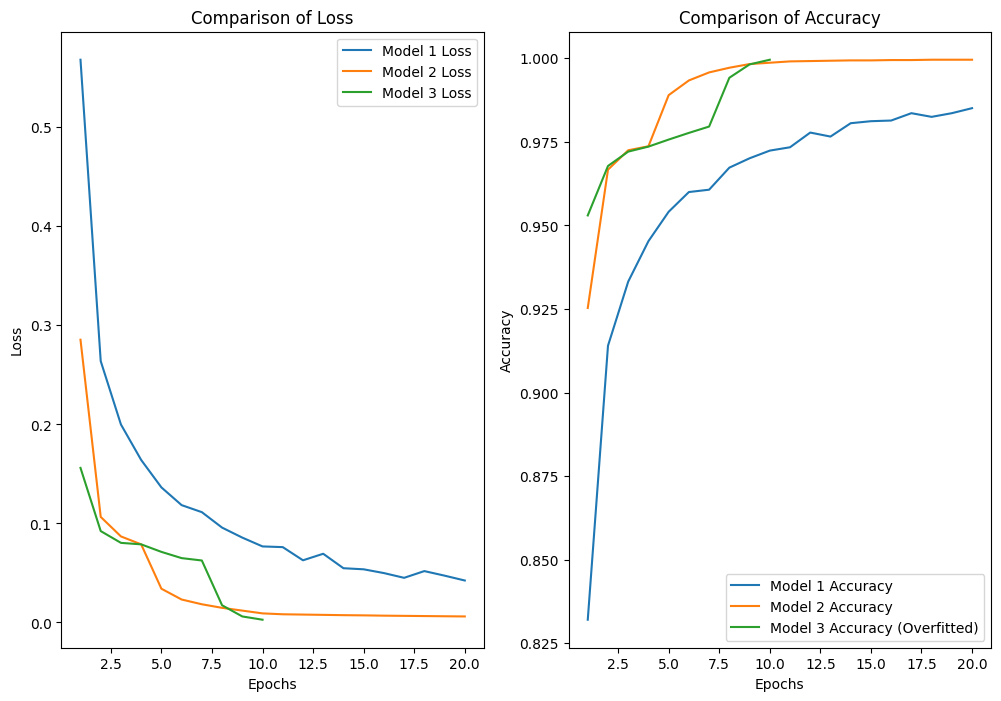

In [1]:
import matplotlib.pyplot as plt

Model1 = {
    "loss": [0.5682, 0.2639, 0.1999, 0.1641, 0.1364, 0.1185, 0.1114, 0.0958, 0.0857, 0.0768, 0.0761, 0.0628, 0.0694, 0.0548, 0.0537, 0.0499, 0.0451, 0.0519, 0.0473, 0.0424],
    "accuracy": [0.8320, 0.9140, 0.9332, 0.9453, 0.9541, 0.9600, 0.9607, 0.9673, 0.9701, 0.9724, 0.9734, 0.9778, 0.9766, 0.9806, 0.9812, 0.9814, 0.9836, 0.9825, 0.9836, 0.9851]
}
Model2 = {
    "loss": [0.2855, 0.1066, 0.0869, 0.0789, 0.0341, 0.0232, 0.0184, 0.0148, 0.012, 0.0092, 0.0083, 0.008, 0.0077, 0.0074, 0.0072, 0.0069, 0.0067, 0.0065, 0.0063, 0.0061],
    "accuracy": [0.9253, 0.9667, 0.9725, 0.9737, 0.989, 0.9934, 0.9958, 0.9972, 0.9983, 0.9987, 0.9991, 0.9992, 0.9993, 0.9994, 0.9994, 0.9995, 0.9995, 0.9996, 0.9996, 0.9996]
}
Model3 = {
    "loss": [0.1561, 0.0923, 0.0804, 0.0789, 0.0713, 0.0650, 0.0626, 0.0174, 0.0061, 0.0028],
    "accuracy": [0.9530, 0.9678, 0.9721, 0.9736, 0.9757, 0.9777, 0.9796, 0.9942, 0.9982, 0.9996]
}

epochs_range1 = range(1, len(Model1["loss"]) + 1)
epochs_range2 = range(1, len(Model2["loss"]) + 1)
epochs_range3 = range(1, len(Model3["loss"]) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range1, Model1["loss"], label='Model 1 Loss')
plt.plot(epochs_range2, Model2["loss"], label='Model 2 Loss')
plt.plot(epochs_range3, Model3["loss"], label='Model 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Comparison of Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range1, Model1["accuracy"], label='Model 1 Accuracy')
plt.plot(epochs_range2, Model2["accuracy"], label='Model 2 Accuracy')
plt.plot(epochs_range3, Model3["accuracy"], label='Model 3 Accuracy (Overfitted)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Comparison of Accuracy')

plt.show()

